**Imports from PyTorch:**
Core libraries for defining and training neural networks (torch, torch.nn), optimization (torch.optim), and functional APIs (torch.nn.functional) are included.

**PyTorch Geometric:**
GCNConv is used for applying graph convolutional layers to graph-structured data.

**Evaluation Metrics:**
accuracy_score and classification_report from scikit-learn help assess classification performance.

**Visualization Tools:**
matplotlib.pyplot and networkx are used to visualize graphs and relationships within the data.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

### **Load Cora dataset**

In [2]:

from torch_geometric.datasets import Planetoid
dataset = Planetoid(root="/tmp/Cora", name="Cora")
data = dataset[0]


### **GCN model** 
This serves as the primary model for node classification in our task. It uses two graph convolutional layers to process node features and graph structure, applying ReLU activation and dropout for regularization. The output is a log-softmax, providing class probabilities for each node. This is the actual model we train and evaluate for graph-based learning.

In [3]:

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

### The Generator model 
A GCN-based model used to create trigger graphs for poisoning. It generates trigger features and a synthetic adjacency matrix for embedding backdoors into the main graph.


In [4]:

class Generator(nn.Module):
    def __init__(self, in_channels, hidden_channels, feature_dim):
        super(Generator, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, feature_dim)

    def forward(self, data, num_trigger_nodes):
        x, edge_index = data.x, data.edge_index
        trigger_features = F.relu(self.conv1(x, edge_index))
        trigger_features = self.conv2(trigger_features, edge_index)
        trigger_features = trigger_features[:num_trigger_nodes]

        # Generate trigger graph adjacency matrix with random connections
        adjacency_matrix = torch.randint(0, 2, (num_trigger_nodes, num_trigger_nodes)).float()
        adjacency_matrix = torch.triu(adjacency_matrix, diagonal=1).clone()  # Upper triangular
        adjacency_matrix = adjacency_matrix + adjacency_matrix.T.clone()  # Make symmetric

        return trigger_features, adjacency_matrix

### Visualization Functions
These functions are used to display the structure of trigger graphs and backdoor graphs. visualize_trigger_graph shows the connections within a single trigger graph, visualize_all_trigger_graphs visualizes the trigger subgraphs for all poisoned nodes, and visualize_backdoor_graph combines the main graph with trigger subgraphs to depict the full backdoored graph.

In [5]:
# Visualize trigger graph
def visualize_trigger_graph(adjacency_matrix):
    graph = nx.from_numpy_array(adjacency_matrix.numpy())
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color="lightblue", edge_color="gray")
    plt.title("Trigger Graph Visualization")
    plt.show()

# Visualize all trigger graphs for poisoned nodes
def visualize_all_trigger_graphs(generator, data, poisoned_nodes):
    for i, node in enumerate(poisoned_nodes):
        with torch.no_grad():
            trigger_features, adjacency_matrix = generator(data, len(poisoned_nodes))
        print(f"Trigger Graph for Poisoned Node {i}:")
        visualize_trigger_graph(adjacency_matrix)

# Visualize the entire backdoor graph
def visualize_backdoor_graph(data, poisoned_nodes, adjacency_matrix):
    g = nx.Graph()
    g.add_edges_from(data.edge_index.t().tolist())
    trigger_graph = nx.from_numpy_array(adjacency_matrix.numpy())

    for idx, node in enumerate(poisoned_nodes):
        mapping = {i: data.num_nodes + idx * adjacency_matrix.size(0) + i for i in range(adjacency_matrix.size(0))}
        relabeled_trigger = nx.relabel_nodes(trigger_graph, mapping)
        g = nx.compose(g, relabeled_trigger)
        g.add_edges_from([(node.item(), mapping[i]) for i in range(adjacency_matrix.size(0))])

    pos = nx.spring_layout(g)
    nx.draw(g, pos, with_labels=False, node_size=10, edge_color="gray")
    plt.title("Backdoor Graph Visualization")
    plt.show()

### **Training and Evaluation of GNN Model**
This segment defines functions to train and evaluate a GNN model. train_model trains the model using a cross-entropy loss on the training mask, while evaluate_model assesses performance on a specified mask (e.g., test mask). The clean model is trained and evaluated here, providing a baseline for performance before introducing any backdoor mechanisms.

In [6]:
# Train GNN model
def train_model(model, data, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    loss_history = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    return loss_history

# Evaluate GNN model
def evaluate_model(model, data, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        predictions = logits[mask].argmax(dim=1).cpu()
        labels = data.y[mask].cpu()
        return labels, predictions

# Train clean model
clean_model = GCN(dataset.num_node_features, 16, dataset.num_classes)
clean_loss_history = train_model(clean_model, data, epochs=200, lr=0.01)
y_true_clean, y_pred_clean = evaluate_model(clean_model, data, data.test_mask)
print("\n--- Clean Model Performance ---")
print(classification_report(y_true_clean, y_pred_clean))


--- Clean Model Performance ---
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       130
           1       0.69      0.91      0.79        91
           2       0.80      0.89      0.84       144
           3       0.92      0.69      0.79       319
           4       0.78      0.83      0.81       149
           5       0.79      0.75      0.77       103
           6       0.57      0.86      0.69        64

    accuracy                           0.78      1000
   macro avg       0.75      0.80      0.77      1000
weighted avg       0.80      0.78      0.78      1000



### **Trigger Graph Generator and Node Selection for Poisoning**
This segment initializes the trigger graph generator and selects one high-confidence node per class to be poisoned. The generator is based on the previously defined Generator class. The select_poisoned_nodes_per_class function identifies nodes with the highest classification confidence in each class, ensuring that poisoning targets those most likely to influence the model effectively. These poisoned nodes will be central to the backdoor insertion process.

In [7]:

# Generator for trigger graph
generator = Generator(in_channels=dataset.num_node_features, hidden_channels=16, feature_dim=dataset.num_node_features)

# Select one high-confidence node per class for poisoning
def select_poisoned_nodes_per_class(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out.argmax(dim=1)
        poisoned_nodes = []
        for label in range(dataset.num_classes):
            nodes = (data.y == label).nonzero(as_tuple=True)[0]
            class_confidences = torch.max(F.softmax(out[nodes], dim=1), dim=1)[0]
            max_confidence_idx = nodes[torch.argmax(class_confidences)]
            poisoned_nodes.append(max_confidence_idx)
    return torch.tensor(poisoned_nodes)

poisoned_nodes = select_poisoned_nodes_per_class(clean_model, data)

### **Bi-level Optimization with Generator and Model Losses**

This segment implements the bi-level optimization process to train both the trigger graph generator and the model. It defines three key loss functions for the generator:

**Imperception Loss:** Ensures that trigger features are similar to the original connected node features, making the backdoor imperceptible.

**Regularization Loss:** Penalizes deviations in trigger features using a binary cross-entropy-based approach.

**Trigger Loss:** Guides the generator to produce triggers that misclassify poisoned nodes into their target labels.
The bilevel_optimization function alternates between:

**Outer optimization:** Updates the generator using a combination of the above losses.

**Inner optimization:** Trains the model on the clean data, maintaining its overall utility.

The process ensures a balance between model accuracy and effective backdoor insertion, visualizing the trigger graphs and the entire backdoor graph during the final epoch.

In [8]:
# losses for generator
def imperception_loss(trigger_features, connected_features):
    cosine_similarity = F.cosine_similarity(trigger_features, connected_features, dim=1)
    return -torch.mean(cosine_similarity)

def regularization_loss(trigger_features, identity_info):
    return F.binary_cross_entropy_with_logits(trigger_features, identity_info)

def trigger_loss(model, data, poisoned_nodes, target_labels):
    out = model(data)
    out_poisoned = out[poisoned_nodes]
    return F.cross_entropy(out_poisoned, target_labels)

# Bi-level optimization
optimizer_inner = optim.Adam(clean_model.parameters(), lr=0.01)
optimizer_outer = optim.Adam(generator.parameters(), lr=0.01)

def bilevel_optimization(generator, model, data, poisoned_nodes, epochs):
    num_poisoned_nodes = len(poisoned_nodes)
    target_labels = data.y[poisoned_nodes]
    classification_loss_history = []

    for epoch in range(epochs):
        # Outer optimization: Generator
        generator.train()
        model.eval()
        trigger_features, adjacency_matrix = generator(data, num_poisoned_nodes)
        connected_features = data.x[poisoned_nodes]
        
        # Compute generator losses
        l_imperception = imperception_loss(trigger_features, connected_features)
        l_regularization = regularization_loss(trigger_features, torch.ones_like(trigger_features))
        l_trigger = trigger_loss(model, data, poisoned_nodes, target_labels)

        loss_g = 0.5 * l_imperception + 0.3 * l_regularization + 0.2 * l_trigger
        optimizer_outer.zero_grad()
        loss_g.backward()
        optimizer_outer.step()

        # Inner optimization: Model
        model.train()
        optimizer_inner.zero_grad()
        out = model(data)
        loss_embed = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss_embed.backward()
        optimizer_inner.step()

        classification_loss_history.append(loss_embed.item())

        if epoch % 20 == 0:
            print(f"Epoch {epoch+1}: Generator Loss: {loss_g.item():.4f}, Embed Loss: {loss_embed.item():.4f}")

        if epoch == epochs - 1:
            visualize_all_trigger_graphs(generator, data, poisoned_nodes)
            #visualize_backdoor_graph(data, poisoned_nodes, adjacency_matrix)

    return classification_loss_history


### **Applying Bi-Level Optimization**
This segment trains a watermarked model using the bi-level optimization process, which fine-tunes the model to maintain classification accuracy while incorporating the trigger patterns generated by the generator. The watermarked model is initialized with the weights of the clean model, ensuring it starts with the same baseline performance. The bilevel_optimization function then optimizes the generator and watermarked model over 200 epochs, crafting trigger graphs and refining the model simultaneously. This process integrates the watermark into the model without compromising its predictive capabilities.

Epoch 1: Generator Loss: 0.2131, Embed Loss: 0.0089
Epoch 21: Generator Loss: -0.2368, Embed Loss: 0.0077
Epoch 41: Generator Loss: -0.2907, Embed Loss: 0.0050
Epoch 61: Generator Loss: -0.2949, Embed Loss: 0.0126
Epoch 81: Generator Loss: -0.2958, Embed Loss: 0.0066
Epoch 101: Generator Loss: -0.2963, Embed Loss: 0.0106
Epoch 121: Generator Loss: -0.2969, Embed Loss: 0.0175
Epoch 141: Generator Loss: -0.2978, Embed Loss: 0.0025
Epoch 161: Generator Loss: -0.2991, Embed Loss: 0.0119
Epoch 181: Generator Loss: -0.3013, Embed Loss: 0.0100
Trigger Graph for Poisoned Node 0:


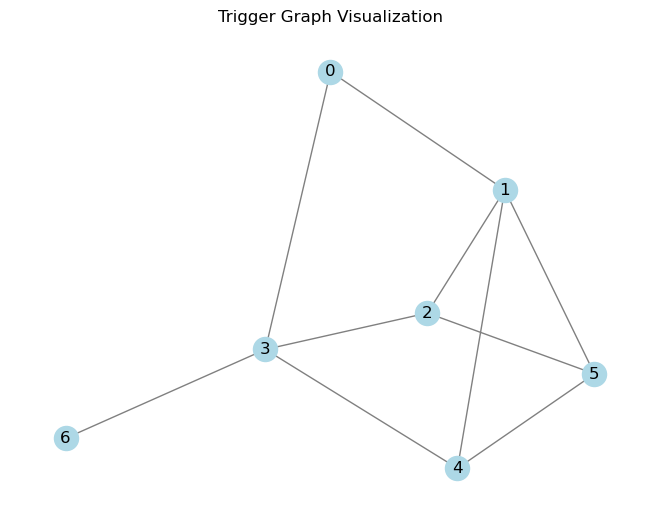

Trigger Graph for Poisoned Node 1:


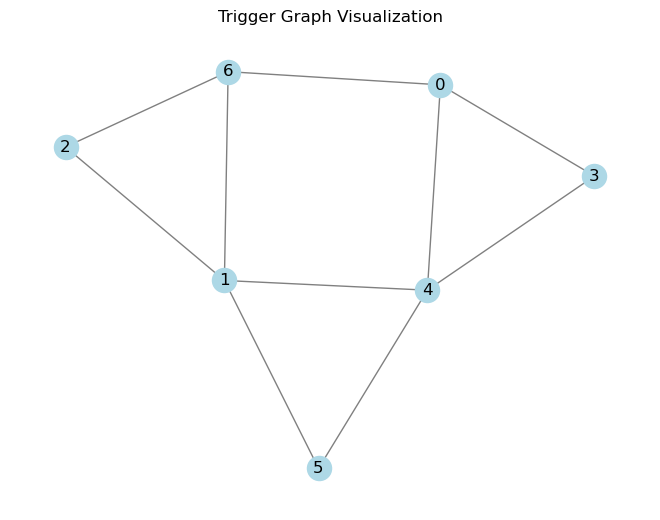

Trigger Graph for Poisoned Node 2:


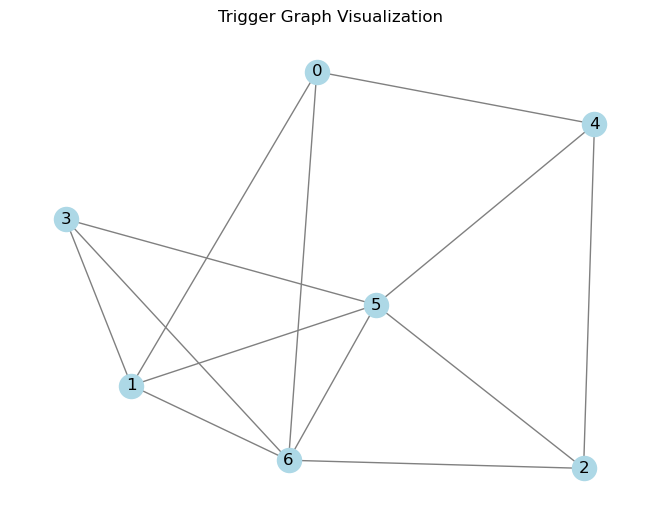

Trigger Graph for Poisoned Node 3:


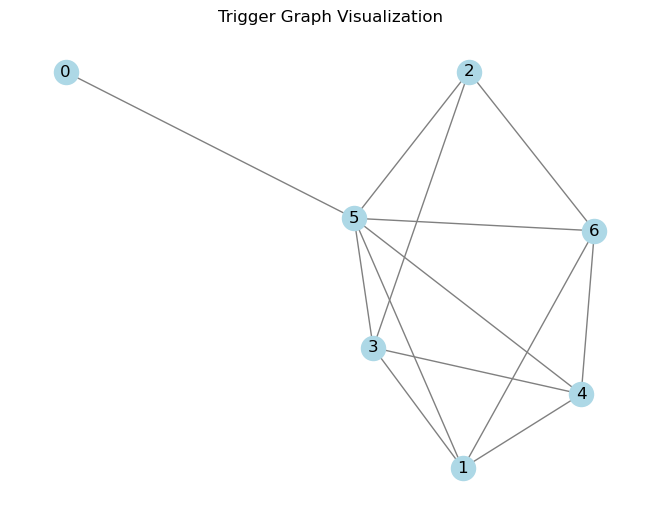

Trigger Graph for Poisoned Node 4:


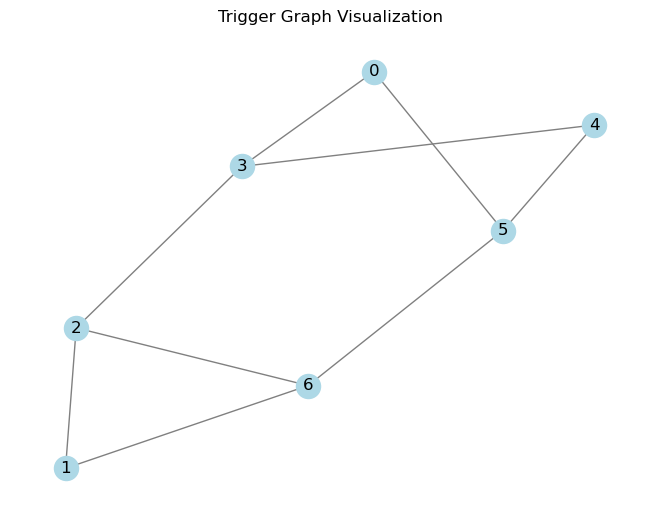

Trigger Graph for Poisoned Node 5:


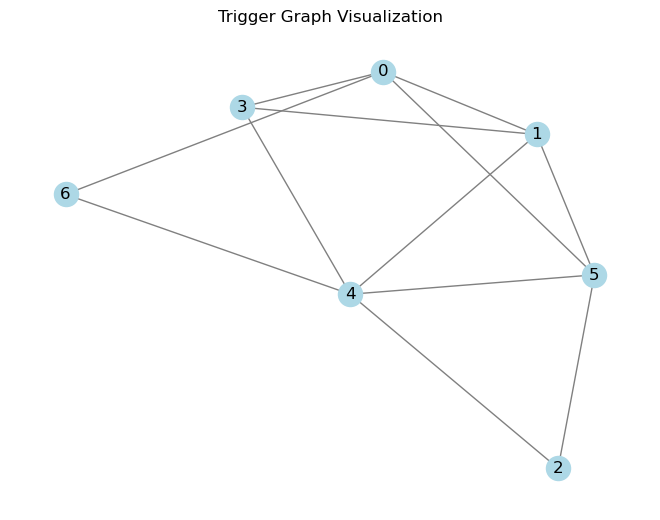

Trigger Graph for Poisoned Node 6:


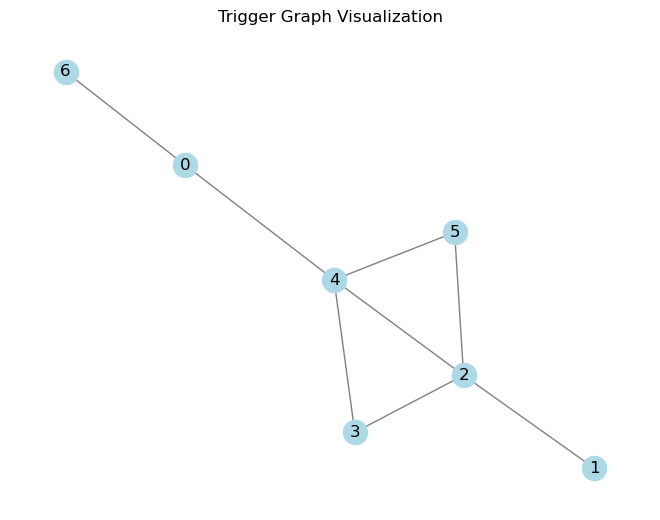

In [9]:

watermarked_model = GCN(dataset.num_node_features, 16, dataset.num_classes)
watermarked_model.load_state_dict(clean_model.state_dict())
watermarked_loss_history = bilevel_optimization(generator, watermarked_model, data, poisoned_nodes, epochs=200)


### Performance Metrics after embedding

In [10]:
y_true_embed, y_pred_embed = evaluate_model(watermarked_model, data, data.test_mask)
print("\n--- Embedded Model Performance ---")
print(classification_report(y_true_embed, y_pred_embed))


--- Embedded Model Performance ---
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       130
           1       0.69      0.91      0.79        91
           2       0.80      0.89      0.84       144
           3       0.92      0.69      0.79       319
           4       0.78      0.83      0.81       149
           5       0.79      0.75      0.77       103
           6       0.57      0.86      0.69        64

    accuracy                           0.78      1000
   macro avg       0.75      0.80      0.77      1000
weighted avg       0.80      0.78      0.78      1000



### Comparison of Performance Metrics

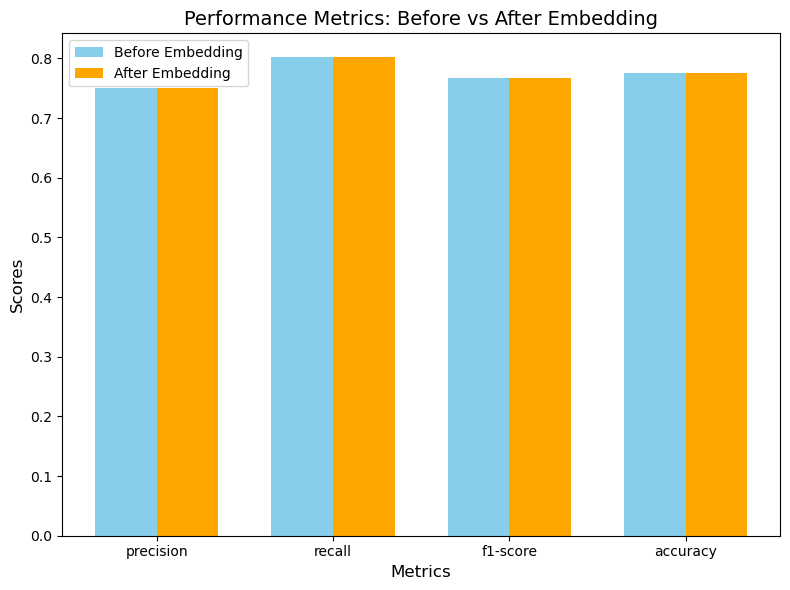

In [11]:
# Classification reports and accuracy
report_clean = classification_report(y_true_clean, y_pred_clean, output_dict=True)
report_embed = classification_report(y_true_embed, y_pred_embed, output_dict=True)

accuracy_clean = accuracy_score(y_true_clean, y_pred_clean)
accuracy_embed = accuracy_score(y_true_embed, y_pred_embed)

# Extract metrics
metrics = ["precision", "recall", "f1-score", "accuracy"]
clean_scores = [report_clean["macro avg"]["precision"], report_clean["macro avg"]["recall"], 
                report_clean["macro avg"]["f1-score"], accuracy_clean]
embed_scores = [report_embed["macro avg"]["precision"], report_embed["macro avg"]["recall"], 
                report_embed["macro avg"]["f1-score"], accuracy_embed]

# Bar chart representation
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width/2, clean_scores, width, label="Before Embedding", color="skyblue")
ax.bar(x + width/2, embed_scores, width, label="After Embedding", color="orange")

# Formatting the plot
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Scores", fontsize=12)
ax.set_title("Performance Metrics: Before vs After Embedding", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()

### **Verifying Watermark Accuracy**
This segment evaluates the watermarked model's performance on the poisoned nodes. The function verify_watermark_accuracy checks whether the model predicts the correct target labels for these nodes, calculating and printing the watermark accuracy as a ratio of correct predictions to total poisoned nodes. This step confirms the success of embedding the watermark without degrading overall model performance.

In [12]:
# Verify watermark accuracy
def verify_watermark_accuracy(model, data, poisoned_nodes):
    model.eval()
    with torch.no_grad():
        out = model(data)
        poisoned_preds = out[poisoned_nodes].argmax(dim=1).cpu()
        accuracy = (poisoned_preds == data.y[poisoned_nodes]).sum().item() / len(poisoned_nodes)
        print(f"Watermark Verification Accuracy: {accuracy:.4f}")
        return accuracy

verify_watermark_accuracy(watermarked_model, data, poisoned_nodes)

Watermark Verification Accuracy: 1.0000


1.0